## Data Visualization - City of Austin Shared Micromobility Vehicle Trips Data

In [1]:
# Dependencies and packages
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import datetime as dt
import pandas as pd
import geopandas as gpd
import plotly.figure_factory as ff
from matplotlib.collections import PatchCollection
import warnings

warnings.filterwarnings("ignore")
%load_ext lab_black

In [2]:
# Read the shared mobility data csv
csvpath = os.path.join("../../resources/merged_sharedmobility.csv")
df = pd.read_csv(csvpath, index_col=0, low_memory=False)

### What days of the week?

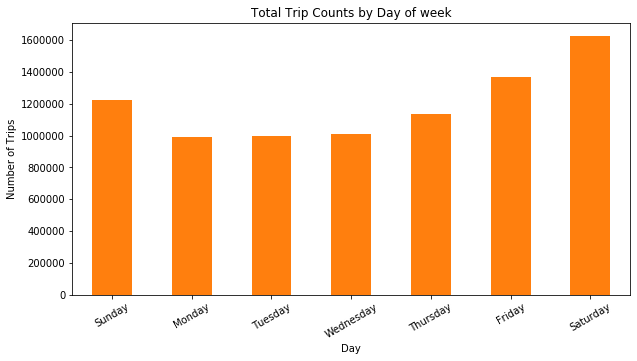

In [7]:
# Count trips per day and sort by day:
daily_total = pd.DataFrame(df["Day Of Week"].value_counts().sort_index())

# Map day of week with actual names:
days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
daily_total["Day"] = days

# Plot glyph:
daily_total.plot(
    kind="bar",
    x="Day",
    y="Day Of Week",
    title="Total Trip Counts by Day of week",
    figsize=(10, 5),
    rot=30,
    color="tab:orange",
    legend=False,
)
plt.ylabel("Number of Trips")
plt.savefig("Plots/trips_per_week.png")
plt.show()

### Which hours of the day are popular?

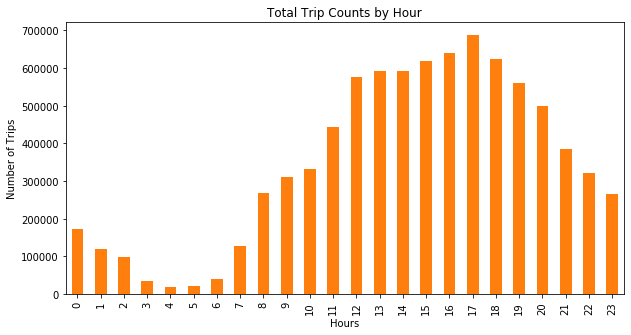

In [8]:
# Count trips per hour and sort by hour:
hourly_total = pd.DataFrame(df["Hour"].value_counts().sort_index())

hourly_total.reset_index().plot(
    kind="bar",
    x="index",
    y="Hour",
    title="Total Trip Counts by Hour",
    figsize=(10, 5),
    color="tab:orange",
    legend=False,
)
plt.xlabel("Hours")
plt.ylabel("Number of Trips")
plt.savefig("Plots/trips_per_hour.png")
plt.show()

### Are some months more popular than others?

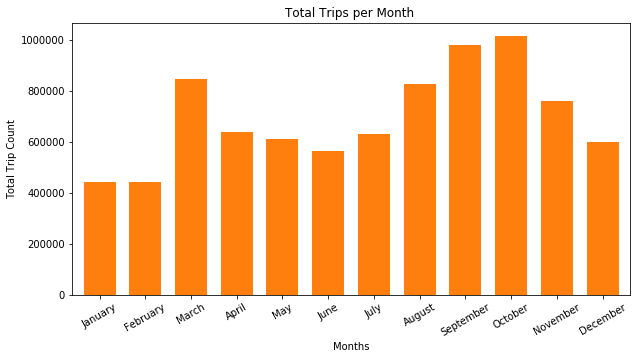

In [9]:
monthly_total = pd.DataFrame(df["Month"].value_counts()).sort_index()
import calendar

mn = [calendar.month_name[int(x)] for x in monthly_total.index.values.tolist()]

monthly_chart = monthly_total.plot.bar(
    title="Total Trips per Month ",
    width=0.7,
    figsize=(10, 5),
    rot=30,
    legend=False,
    color="tab:orange",
)
monthly_chart.set_xticklabels(mn)
monthly_chart.set_xlabel("Months")
monthly_chart.set_ylabel("Total Trip Count")
plt.savefig("Plots/trips_per_month1.png")
plt.show()

## Total daily rides per hour for each day of the week?

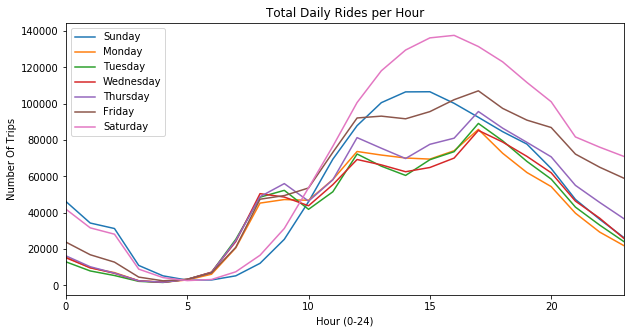

In [129]:
rides_hour_day = df.groupby(by=["Hour", "Day Of Week"]).count()

rides_hour_day = rides_hour_day.reset_index().pivot(
    index="Hour", columns="Day Of Week", values="Trip ID"
)
rides_hour_day.columns = days
rides_hour_day.plot(figsize=(10, 5))

plt.title("Total Daily Rides per Hour")
plt.xlabel("Hour (0-24)")
plt.ylabel("Number Of Trips")
plt.show()
plt.close()

 ## Which census tracts have the most traffic?

In [11]:
# Count how many trips started in each census GEOID tract
census_trip_start = pd.DataFrame(df["Census GEOID Start"].value_counts())
census_trip_start.head(10)

,Census GEOID Start
48453001100,3236435
48453000601,748545
48453000603,601132
48453000604,514316
48453001305,510164
48453000902,456009
48453001200,386962
48453000700,232937
48453001303,204956
48453001401,183566


In [12]:
# Count how many trips ended in each census GEOID tract
census_trip_end = pd.DataFrame(df["Census GEOID End"].value_counts())

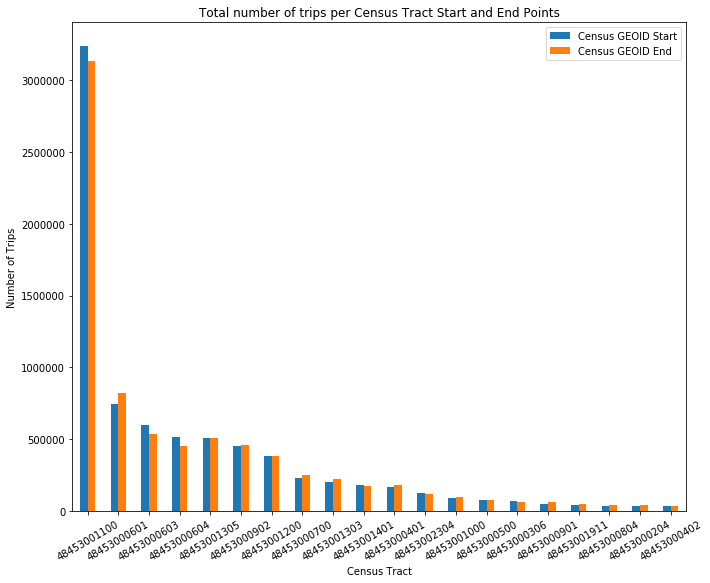

In [13]:
# Only for top 20 popular census tracts
census_traffic = census_trip_start.join(census_trip_end, how="inner")
census_traffic.head(20).plot(kind="bar", figsize=(11, 9), rot=30)
plt.title("Total number of trips per Census Tract Start and End Points")
plt.xlabel("Census Tract")
plt.ylabel("Number of Trips")
plt.savefig("Plots/trips_per_censustract.png")
plt.show()

## Popular Census Tracts using Geopandas

In [67]:
# Plot the census tracts from the US Census Bureau's shapefile using geopandas.
from shapely.geometry import Point, LineString

map_df = gpd.read_file(
    "../../resources/tl_2010_48453_tract00/tl_2010_48453_tract00.shp"
)
map_df.head(1)

,STATEFP00,COUNTYFP00,TRACTCE00,CTIDFP00,NAME00,NAMELSAD00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,geometry
0,48,453,001766,48453001766,17.66,Census Tract 17.66,G5020,S,279772166,7922100,+30.5486598,-097.9935380,"POLYGON ((-97.95351 30.47734, -97.95502 30.476..."


In [68]:
# Read Austin Streetlines shapefile:
streets = gpd.read_file(
    "../../resources/Street Centerline/geo_export_c8b73b25-2ed4-4cce-b27a-5b77fe19ba06.shp"
)
streets = streets.to_crs(map_df.crs)

### Plot for Popular Census Tracts to START rides

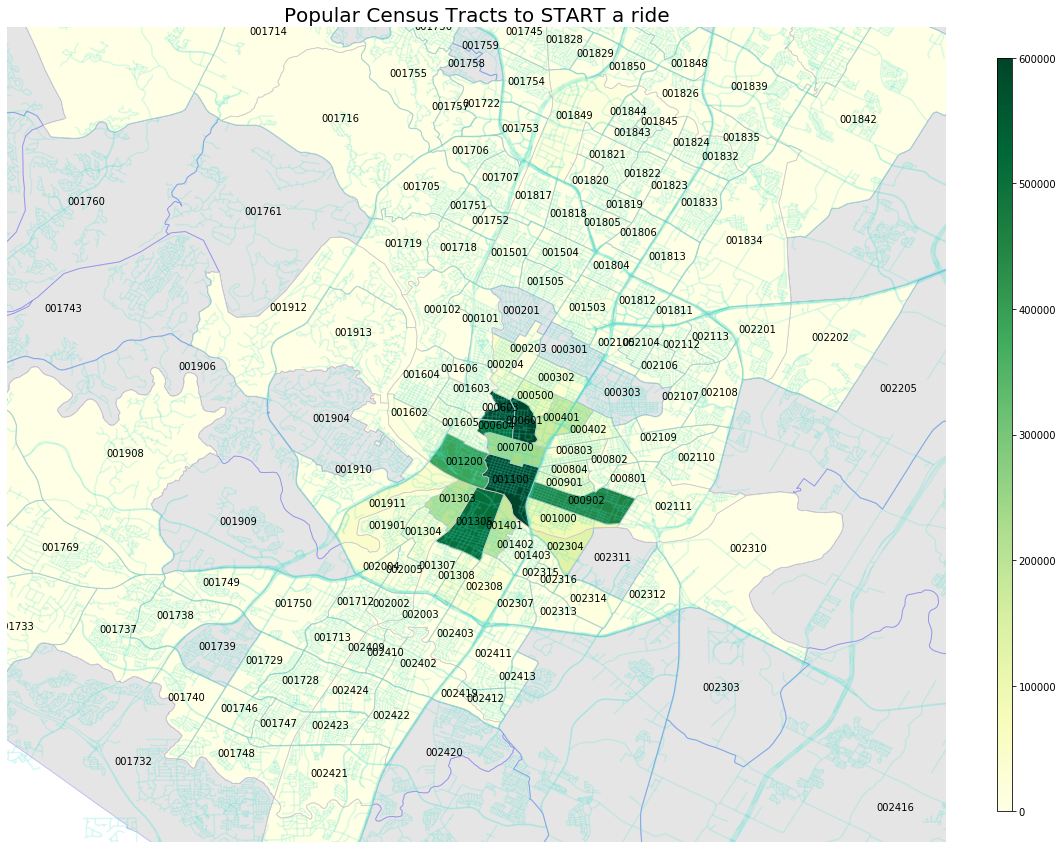

In [69]:
# Create a plot using geopandas and choropleth of census tract starts
_, ax = plt.subplots(figsize=(18, 18))

# Match the datatypes
map_df["CTIDFP00"] = map_df["CTIDFP00"].astype("int64")
map_df[["INTPTLAT00", "INTPTLON00"]] = map_df[["INTPTLAT00", "INTPTLON00"]].astype(
    "float64"
)

# Merge the geodataframe with the census starts dataframe
starts_plot = map_df.set_index("CTIDFP00").join(census_trip_start, how="inner")

vmax_start = 600000
vmin_start = 0
# Render the glyphs:
map_df.plot(ax=ax, color="grey", edgecolor="blue", alpha=0.2)
starts_plot.plot(
    ax=ax,
    column="Census GEOID Start",
    cmap="YlGn",
    linewidth=0.8,
    edgecolor="0.8",
    vmax=vmax_start,
    vmin=vmin_start,
)
streets.plot(ax=ax, color="turquoise", alpha=0.2)

# Label census tracts
for idx, row in map_df.iterrows():
    plt.annotate(
        s=row["TRACTCE00"],
        xy=(row["INTPTLON00"], row["INTPTLAT00"]),
        horizontalalignment="center",
        clip_on=True,
    )

# Set the limits of the plot
# To get a zommed out view use: (-97.919881, -97.589348, 30.139918,30.426626)
# For zoomed map use : (-97.79, -97.675, 30.22, 30.31)
bbox = (-97.919881, -97.589348, 30.139918, 30.426626)
plt.xlim(bbox[0], bbox[1])
plt.ylim(bbox[2], bbox[3])


plt.axis("off")
plt.title("Popular Census Tracts to START a ride", fontsize=20)
sm_start = plt.cm.ScalarMappable(
    cmap="YlGn", norm=plt.Normalize(vmin=vmin_start, vmax=vmax_start)
)

plt.colorbar(sm_start, fraction=0.015, aspect=50)
plt.savefig("Plots/choropeth_tractstart.png")
plt.show()

### Plot for Popular Census Tracts to END rides

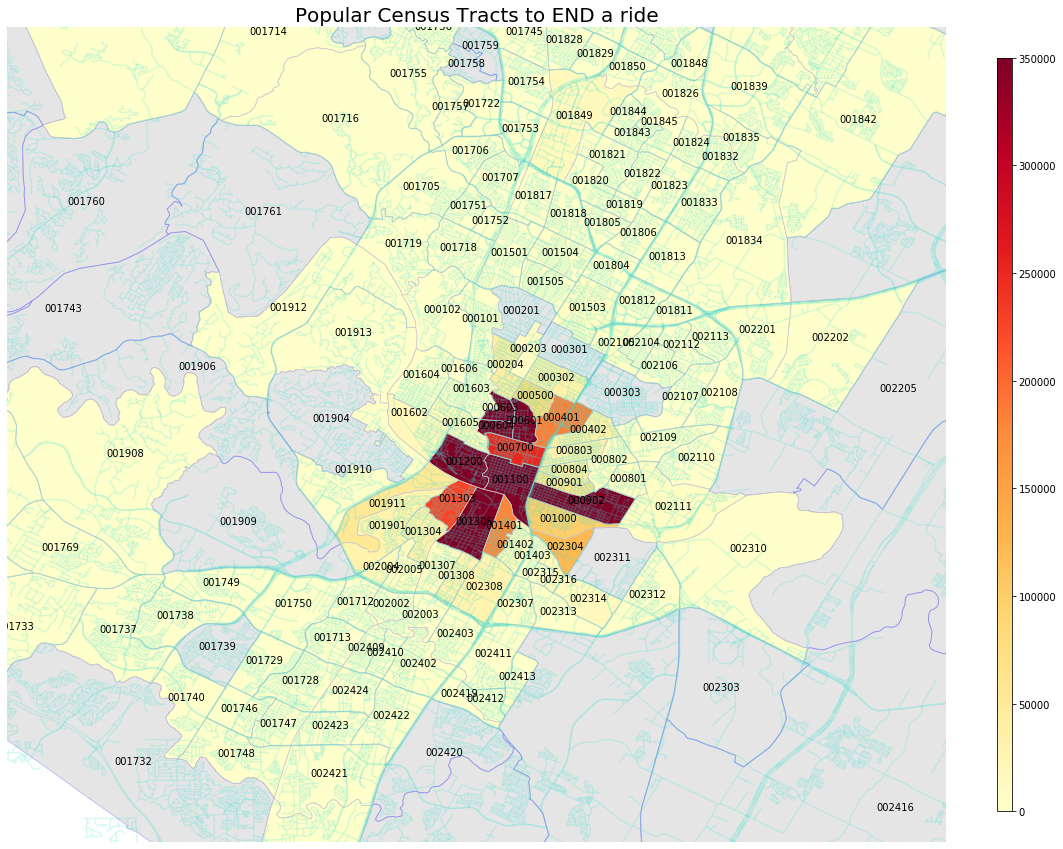

In [61]:
# Create a plot using geopandas and choropleth of census tract starts
_, ax = plt.subplots(figsize=(18, 18))

# Merge the geodataframe with the census starts dataframe
ends_plot = map_df.set_index("CTIDFP00").join(census_trip_end, how="inner")

vmax_start = 350000
vmin_start = 0
# Render the glyphs:
map_df.plot(ax=ax, color="grey", edgecolor="blue", alpha=0.2)
ends_plot.plot(
    ax=ax,
    column="Census GEOID End",
    cmap="YlOrRd",
    linewidth=0.8,
    edgecolor="0.8",
    vmax=vmax_start,
    vmin=vmin_start,
)
streets.plot(ax=ax, color="turquoise", alpha=0.2)


# Label census tracts
for idx, row in map_df.iterrows():
    plt.annotate(
        s=row["TRACTCE00"],
        xy=(row["INTPTLON00"], row["INTPTLAT00"]),
        horizontalalignment="center",
        clip_on=True,
    )

# Set the limits of the plot
# To get a zommed out view use: (-97.919881, -97.589348, 30.139918,30.426626)
# For zoomed map use : (-97.79, -97.675, 30.22, 30.31)
bbox = (-97.919881, -97.589348, 30.139918, 30.426626)
plt.xlim(bbox[0], bbox[1])
plt.ylim(bbox[2], bbox[3])


plt.axis("off")
plt.title("Popular Census Tracts to END a ride", fontsize=20)
sm_end = plt.cm.ScalarMappable(
    cmap="YlOrRd", norm=plt.Normalize(vmin=vmin_start, vmax=vmax_start)
)

plt.colorbar(sm_end, fraction=0.015, aspect=50)
plt.savefig("Plots/choropeth_tractend.png")
plt.show()

### Which Zipcodes have the most traffic?

In [15]:
# Count how many trips started in each census GEOID tract
zipcode_start = pd.DataFrame(df["Zipcode Start"].value_counts())

In [16]:
# Count how many trips ended in each census tract
zipcode_end = pd.DataFrame(df["Zipcode End"].value_counts())

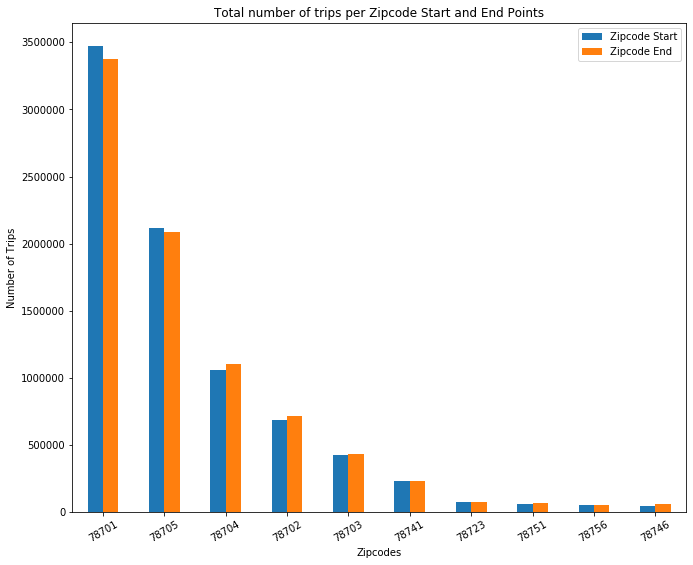

In [17]:
# Only for top 10 popular zipcodes
zipcode_traffic = zipcode_start.join(zipcode_end, how="inner")
zipcode_traffic.head(10).plot(kind="bar", figsize=(11, 9), rot=30)
plt.title("Total number of trips per Zipcode Start and End Points")
plt.xlabel("Zipcodes")
plt.ylabel("Number of Trips")
plt.savefig("Plots/trips_per_zipcode.png")
plt.show()

## Popular routes to start/end a trip? (Further work)
#### Find the center of the shapefiles and join with a line for start and end census tracts:

In [70]:
polygon_lookup = (
    map_df[["CTIDFP00", "geometry"]].set_index("CTIDFP00")["geometry"].to_dict()
)


def get_center_from_polygon(polygon):
    x = polygon.centroid.x
    y = polygon.centroid.y
    return x, y


def get_center_from_tract_id(id):
    return get_center_from_polygon(polygon_lookup[id])

In [71]:
get_center_from_tract_id(48453001100)

(-97.74242913204495, 30.266198038162536)

In [89]:
get_center_from_tract_id(48453002308)

(-97.75216193765651, 30.22901330799064)

In [38]:
get_center_from_polygon(map_df["geometry"][0])

(-97.99812630645184, 30.539390025720902)

In [43]:
df_agg = df.groupby(["Census GEOID Start", "Census GEOID End"]).count()
df_agg = df_agg.reset_index().sort_index(ascending=True)
top_df = df_agg.head(10)
top_df

,Census GEOID Start,Census GEOID End,Trip ID,Device ID,Modified Date,Council District Start,Council District End,Vehicle Type,Trip Duration,Trip Distance,Start Time,End Time,Month,Hour,Day Of Week,Year,Zipcode Start,Zipcode End
0,48021950100,48453001100,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,48021950801,48021950801,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2,48021950802,48021950802,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
3,48021950802,48453000603,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,48209010809,48209010809,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,48209010901,48209010901,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,48209010901,48453000604,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,48209010901,48453001100,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
8,48209010901,48453001305,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
9,48453000101,48453000101,1262,1262,1262,1262,1262,1262,1262,1262,1262,1262,1262,1262,1262,1262,1262,1262


In [ ]:
for idx, row in top_df.iterrows():
    s_x, s_y = get_center_from_tract_id(row["Census GEOID Start"])    
    e_x, e_y = get_center_from_tract_id(row["Census GEOID End"])    
    plt.plot([s_x,e_x], [s_y,e_y])

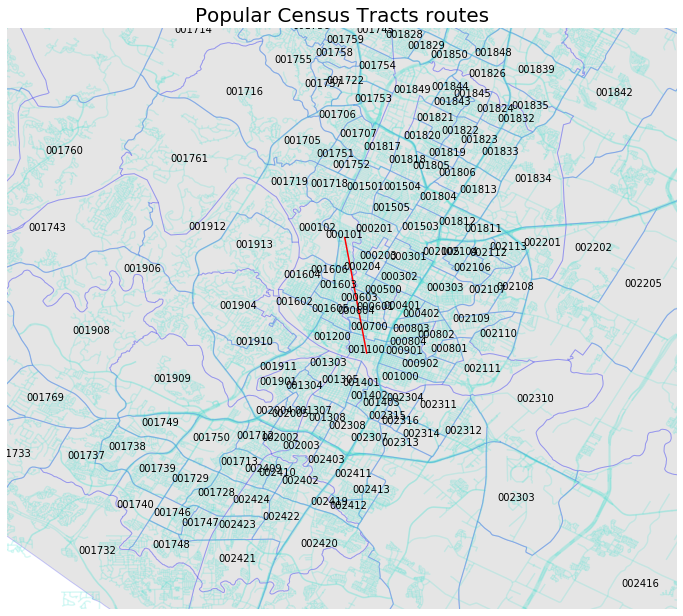

In [72]:
_, ax = plt.subplots(figsize=(12, 12))

# Render the glyphs:
map_df.plot(ax=ax, color="grey", edgecolor="blue", alpha=0.2)
streets.plot(ax=ax, color="turquoise", alpha=0.2)

"""""" """
for idx, row in top_df.iterrows():
    s_x, s_y = get_center_from_tract_id(row["Census GEOID Start"])
    e_x, e_y = get_center_from_tract_id(row["Census GEOID End"])
    plt.plot([s_x,e_x], [s_y,e_y])
""" """"""

s_x, s_y = get_center_from_tract_id(48453001100)
e_x, e_y = get_center_from_tract_id(48453000101)
plt.plot([s_x, e_x], [s_y, e_y], color="red")

# Label census tracts
for idx, row in map_df.iterrows():
    plt.annotate(
        s=row["TRACTCE00"],
        xy=(row["INTPTLON00"], row["INTPTLAT00"]),
        horizontalalignment="center",
        clip_on=True,
    )

bbox = (-97.919881, -97.589348, 30.139918, 30.426626)
plt.xlim(bbox[0], bbox[1])
plt.ylim(bbox[2], bbox[3])
plt.axis("off")
plt.title("Popular Census Tracts routes", fontsize=20)
plt.show()

In [73]:
top_start = (
    census_trip_start.head(10)
    .reset_index()
    .rename(
        columns={"index": "Census GEOID Start", "Census GEOID Start": "Count Start"}
    )
)


top_end = (
    census_trip_end.head(10)
    .reset_index()
    .rename(columns={"index": "Census GEOID End", "Census GEOID End": "Count End"})
)